# Support Vector Machine

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, GridSearchCV
import sys
from pathlib import Path

# Setup paths to access shared common code (utils)
current_dir = Path.cwd()
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import utils

RANDOM_STATE = 42

In [12]:
# Load the CUP training data
ids, X, y = utils.load_cup_data(train=True)

# Split: 90% Development, 10% Internal Test
# Using the same random_state as the team to ensure consistent splits

X_dev, X_test_internal, y_dev, y_test_internal = utils.split_data(X, y, random_state=RANDOM_STATE)

print(f"Total samples: {len(X)}")
print(f"Development Set shape: {X_dev.shape} (Used for Model Selection)")
print(f"Internal Test Set shape: {X_test_internal.shape} (Used ONLY for final check)")

Total samples: 500
Development Set shape: (450, 12) (Used for Model Selection)
Internal Test Set shape: (50, 12) (Used ONLY for final check)


In [13]:
# Define Hyperparameters to study for the SVM grid search
c_values = [0.1, 1, 10, 100]
epsilon_values = [0.01, 0.1, 0.2]
gamma_values = ['scale', 0.1, 0.01]
kernel_values = ['rbf', 'linear', 'poly']  # Test all kernels

# --------- 5-Fold Cross-Validation with GridSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []

print("Starting SVM Grid Search...")

# Prepare data for scaling
scaler = utils.CupScaler()
X_dev_scaled, y_dev_scaled = scaler.fit_transform(X_dev, y_dev)

# Define parameter grid
param_grid = {
    'estimator__kernel': kernel_values,
    'estimator__C': c_values,
    'estimator__epsilon': epsilon_values,
    'estimator__gamma': gamma_values
}

# Create base SVM model
svm_base = SVR()
regr = MultiOutputRegressor(svm_base)

# Use GridSearchCV
grid_search = GridSearchCV(regr, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_dev_scaled, y_dev_scaled)

# Extract results
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['kernel'] = results_df['param_estimator__kernel']
results_df['C'] = results_df['param_estimator__C']
results_df['eps'] = results_df['param_estimator__epsilon']
results_df['gamma'] = results_df['param_estimator__gamma']
results_df['mee'] = -results_df['mean_test_score']

print("Grid Search Complete.")

Starting SVM Grid Search...
Grid Search Complete.


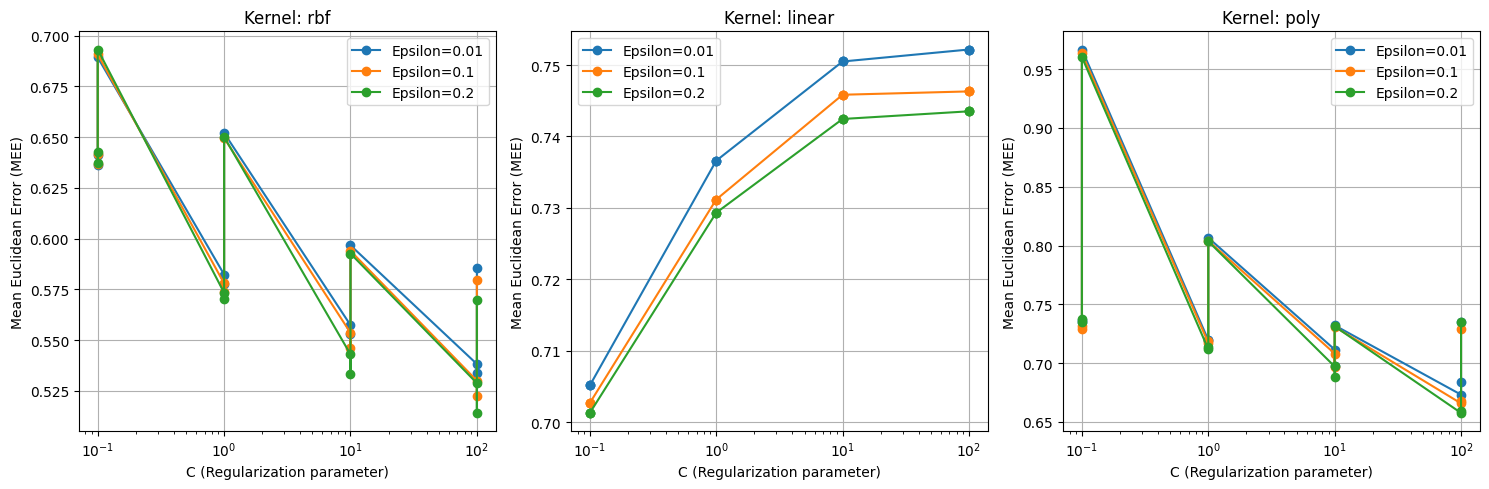

BEST CONFIGURATION: Kernel=rbf, C=100.0, Eps=0.2, Gamma=0.1
Best Validation MEE: 0.5142


In [14]:
# Convert results to DataFrame for easier plotting
# Plot MEE vs C for different epsilon and kernel values
fig, axes = plt.subplots(1, len(kernel_values), figsize=(15, 5))

for idx, kernel in enumerate(kernel_values):
    ax = axes[idx]
    for eps in epsilon_values:
        subset = results_df[(results_df['eps'] == eps) & (results_df['kernel'] == kernel)]
        ax.plot(subset['C'], subset['mee'], marker='o', label=f'Epsilon={eps}')
    
    ax.set_xscale('log') 
    ax.set_title(f'Kernel: {kernel}')
    ax.set_xlabel('C (Regularization parameter)')
    ax.set_ylabel('Mean Euclidean Error (MEE)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Identify the Best Hyperparameters
best_idx = results_df['mee'].idxmin()
best_row = results_df.loc[best_idx]
best_kernel = best_row['kernel']
best_c = best_row['C']
best_eps = best_row['eps']
best_gamma = best_row['gamma']
print(f"BEST CONFIGURATION: Kernel={best_kernel}, C={best_c}, Eps={best_eps}, Gamma={best_gamma}")
print(f"Best Validation MEE: {best_row['mee']:.4f}")

In [16]:
# 1. RETRAIN ON FULL DEVELOPMENT SET with best hyperparameters
final_scaler = utils.CupScaler()
X_dev_scaled, y_dev_scaled = final_scaler.fit_transform(X_dev, y_dev)

final_svm = MultiOutputRegressor(SVR(kernel=best_kernel, C=best_c, epsilon=best_eps, gamma=best_gamma))
final_svm.fit(X_dev_scaled, y_dev_scaled)

# 2. EVALUATE ON INTERNAL TEST SET
X_test_scaled, _ = final_scaler.transform(X_test_internal)
y_test_pred_scaled = final_svm.predict(X_test_scaled)
y_test_pred_original = final_scaler.inverse_transform_y(y_test_pred_scaled)

test_mee = utils.mean_euclidean_error(y_true=y_test_internal, y_pred=y_test_pred_original)

# 3. FINAL REPORT
print("-" * 30)
print(f"FINAL REPORT (SVM)")
print("-" * 30)
print(f"Best Kernel: {best_kernel}")
print(f"Validation MEE (CV): {best_row['mee']:.4f}")
print(f"Internal Test MEE:   {test_mee:.4f}")
print("-" * 30)

------------------------------
FINAL REPORT (SVM)
------------------------------
Best Kernel: rbf
Validation MEE (CV): 0.5142
Internal Test MEE:   23.4194
------------------------------
